KAGGLE TITANIC

POPRAVITI U VISE FILEOVA, JEDAN FILE CE BITI EDA, JEDAN FILE MISSING IMPUTATION, JEDAN FILE FEATURE ENGINEERING, JEDAN FILE MODEL SELECTION

imputation za cabin (missing vlaues)
veza featuresa sa survived (nekakav preliminarni test)
dodatni featuresi
drugi modeli

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
#sklearn
from patsy import dmatrices
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from lightgbm import LGBMClassifier
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu, pearsonr

In [3]:
#data
test=pd.read_csv("C:\\Users\\ante1\OneDrive\\Radna površina\\kaggle titanic\\test.csv")
train=pd.read_csv("C:\\Users\\ante1\\OneDrive\\Radna površina\\kaggle titanic\\train.csv")
#dobro su ucitani

In [4]:
#gledmo missinge i shape
print(test.shape)
print(train.shape)

(418, 11)
(891, 12)


In [5]:
#gledam ima li missinga
print('TRAIN SET MISSING VALUES:')
print(train.isna().sum())
print('')
print('TEST SET MISSING VALUES:')
print(test.isna().sum())

TRAIN SET MISSING VALUES:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

TEST SET MISSING VALUES:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [6]:
print(f'Duplicates in train set: {train.duplicated().sum()}, ({np.round(100*train.duplicated().sum()/len(train),1)}%)')
print('')
print(f'Duplicates in test set: {test.duplicated().sum()}, ({np.round(100*test.duplicated().sum()/len(test),1)}%)')

Duplicates in train set: 0, (0.0%)

Duplicates in test set: 0, (0.0%)


In [7]:
print('Unique values in train set:')
print(train.nunique())
print('Unique values in test set:')
print(test.nunique())

Unique values in train set:
PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64
Unique values in test set:
PassengerId    418
Pclass           3
Name           418
Sex              2
Age             79
SibSp            7
Parch            8
Ticket         363
Fare           169
Cabin           76
Embarked         3
dtype: int64


Malo komentara na navedeno... citajuci sa Kagglea o varijablama mozemo ih u grubo podijeliti u kategorijske i diskretne.

Surivived je dihotomna, zelimo ju predvijdieti (binarna). Kategorijske su Pclass, Sex, Age, Sibsp, parch, embarked.
Dok su ticketm fare i cabin zasad (neprekidne jer imaju puno vrijednosti)

Text(0.5, 1.0, 'Target distribution')

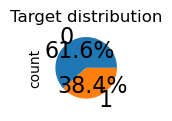

In [8]:
#EDA
#balansiranost uzorka
# Figure size
plt.figure(figsize=(1,1))
# Pie plot
train['Survived'].value_counts().plot.pie(autopct='%1.1f%%', textprops={'fontsize':16}).set_title("Target distribution")

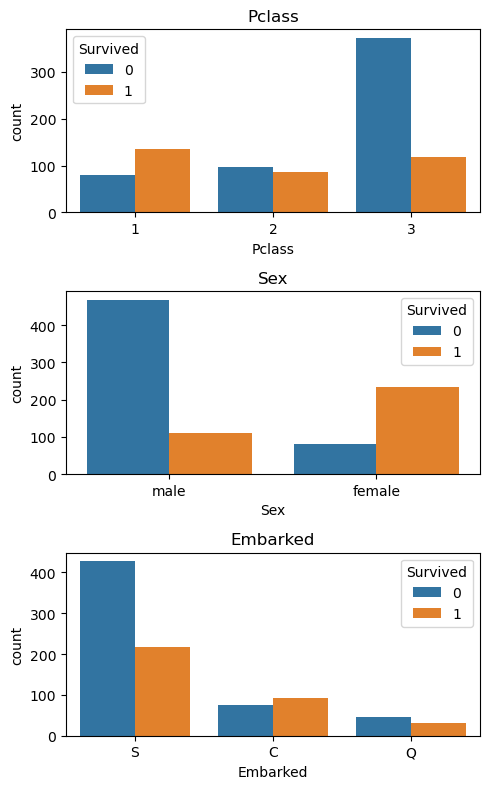

In [9]:
cat_feats=['Pclass', 'Sex', 'Embarked']

# Plot categorical features
fig=plt.figure(figsize=(5,8))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(3,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Survived')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

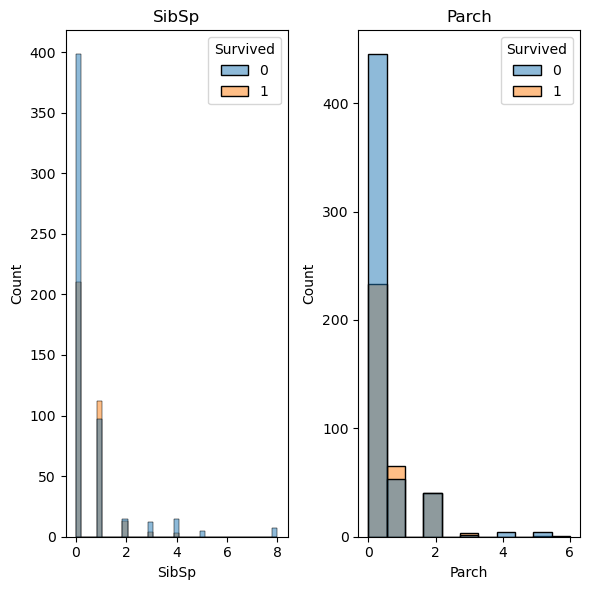

In [10]:
#sada plotamo uz hue
# Plot features
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(1,2,1)
sns.histplot(data=train, x='SibSp', axes=ax, hue='Survived')
ax.set_title('SibSp')
ax=fig.add_subplot(1,2,2)
sns.histplot(data=train, x='Parch', axes=ax, hue='Survived')
ax.set_title('Parch')
fig.tight_layout()  # Improves appearance a bit
plt.show()

In [140]:
#u oba slucaja ividmo jako puno nula i te nule nam kazu da nije imao nikoga te u vecini slucajeva nije prezivio

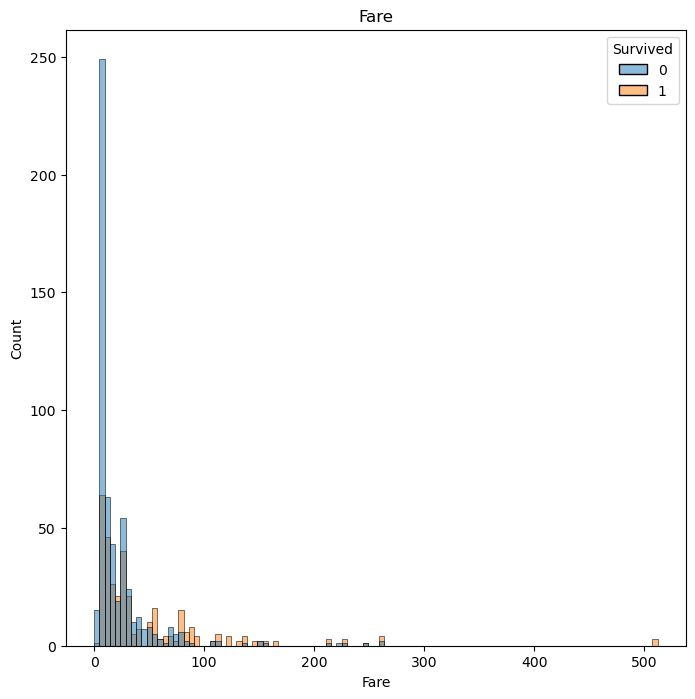

In [11]:
#radimo sad za fare
fig=plt.figure(figsize=(8,8))
sns.histplot(data=train, x='Fare', hue='Survived').set_title('Fare')
plt.show()

POPUNJAVANJE MISSINGA
TRAZIMO NEKAKVE PRAVILNOSTI U ODNOSU NA DRUGE VARIJABLE, POCINJEMO SA IMENOM

In [12]:
#prvo spajam sve podatke u 1 i izbacujem stupac survived
merged_pod = pd.concat([train, test], axis=0)
column_to_drop = 'Survived' 
merged_pod = merged_pod.drop(columns=[column_to_drop])

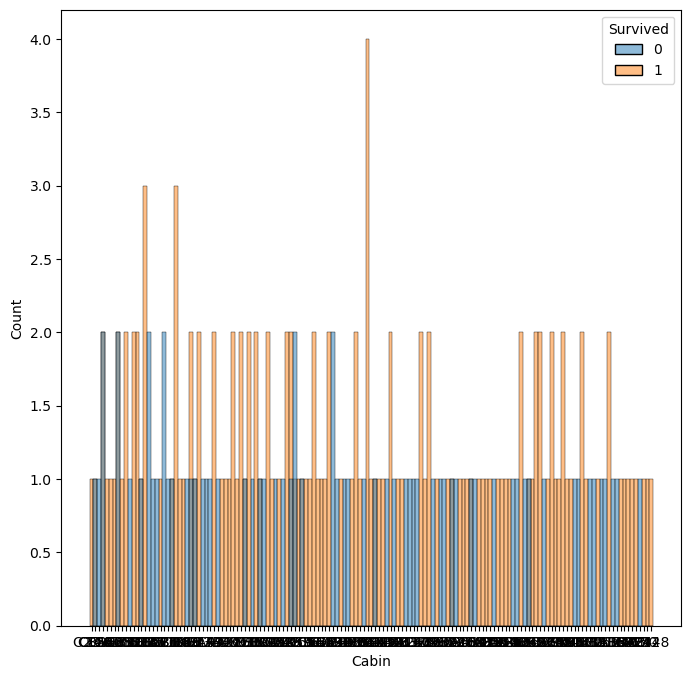

In [14]:
#gledam survived po kabini kako su raspodjeljeni
fig=plt.figure(figsize=(8,8))
sns.histplot(data=train,x='Cabin', hue='Survived')
plt.show()

In [15]:
#indikacija da bi kabina bila jako bitna za prezivaljavanje
#radimo tablicu koja broja przivio po kabini
pd.crosstab(train['Cabin'],train['Survived'])
#podjela je skoro  po uniformna

Survived,0,1
Cabin,,
A10,1,0
A14,1,0
A16,0,1
A19,1,0
A20,0,1
...,...,...
F33,0,3
F38,1,0
F4,0,2


Za cabin ne radimo imputation vec indikaatorsku da li je prazna ili nije

In [62]:
#FARE missing imputation sa medijanom, trebao sam sa S, ali to je mode
merged_pod['Embarked'].fillna(merged_pod['Embarked'].mode()[0], inplace=True)
#sada odmah to updatemo za train
train['Embarked']=merged_pod['Embarked'][0:891]

In [18]:
#median imputaion jer je asimetricna
merged_pod['Fare'].fillna(merged_pod['Fare'].median(), inplace=True)

In [19]:
#AGE IMPUTATION
print(sum(merged_pod['Age'].isna()))
print(sum(merged_pod['Age'].notna()))

263
1046


98


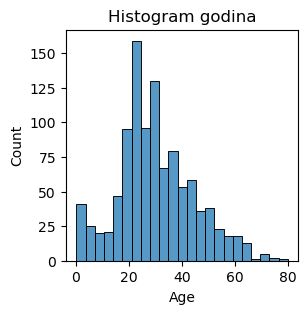

In [21]:
#idemo napraviti histogram
print(merged_pod[merged_pod['Age'].notna()]['Age'].nunique())
fig=plt.figure(figsize=(3,3))
sns.histplot(data=merged_pod[merged_pod['Age'].notna()], x='Age').set_title('Histogram godina')
plt.show()

POPUNJAVANJE MISSINGA ZA AGE MEANOM PO SPOLOVIMA
Gledamo koje bi varijable moge utjecati na godine da odardimo nekakav jednostavni model za impute to su sex, pclass, sibsp, parch, embarked

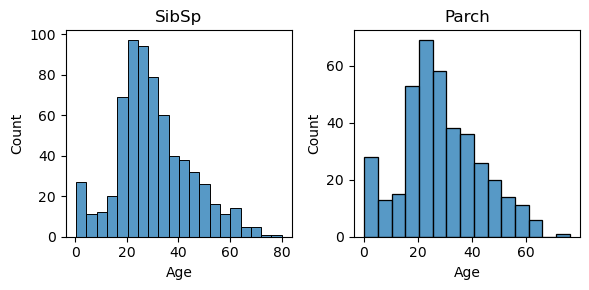

In [22]:
#pitanje je koliko je opravdano imptutati spolove po meanu, skicirati cemo distribucije i vidjeti uopce ima li razlike
merged_age_nna=merged_pod[merged_pod['Age'].notna()]
merged_age_na=merged_pod[merged_pod['Age'].isna()]
fig=plt.figure(figsize=(6,3))
ax=fig.add_subplot(1,2,1)
sns.histplot(data=merged_age_nna[merged_age_nna['Sex'] == 'male'], x='Age', axes=ax)
ax.set_title('SibSp')
ax=fig.add_subplot(1,2,2)
sns.histplot(data=merged_age_nna[merged_age_nna['Sex'] == 'female'], x='Age', axes=ax)
ax.set_title('Parch')
fig.tight_layout()  # Improves appearance a bit
plt.show()

In [151]:
#sada cemo odraditi t test
ttest_ind(merged_age_nna[merged_age_nna['Sex'] == 'male']['Age'],merged_age_nna[merged_age_nna['Sex'] == 'female']['Age'],equal_var=False)
#distribucije su jako jako slicne

TtestResult(statistic=2.04970248345882, pvalue=0.04071969203828953, df=798.3617903959388)

<Axes: xlabel='SibSp', ylabel='Age'>

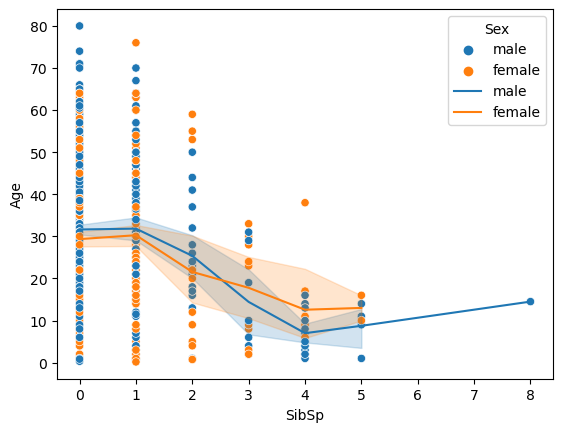

In [23]:
#graficki prikaz imputationa 
sns.scatterplot(data=merged_age_nna,x='SibSp', y='Age',hue='Sex')
sns.lineplot(data=merged_age_nna,x='SibSp', y='Age',hue='Sex')

In [24]:
# vidimo nekakvu negativnu interakciju
#raidmo conversion to dummy za kategorijalnem inace ne bi mogli odraditi fit na regeisju
merged_age_nna=pd.get_dummies(merged_age_nna, columns=['Sex'])
merged_age_na=pd.get_dummies(merged_age_na, columns=['Sex'])

In [25]:
merged_age_na.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male
5,6,3,"Moran, Mr. James",NaN,0,0,330877,8.4583,NaN,Q,False,True
17,18,2,"Williams, Mr. Charles Eugene",NaN,0,0,244373,13.0000,NaN,S,False,True
19,20,3,"Masselmani, Mrs. Fatima",NaN,0,0,2649,7.2250,NaN,C,True,False
26,27,3,"Emir, Mr. Farred Chehab",NaN,0,0,2631,7.2250,NaN,C,False,True
28,29,3,"O'Dwyer, Miss. Ellen ""Nellie""",NaN,0,0,330959,7.8792,NaN,Q,True,False


In [26]:
#gledat cemo linearnu zavisnost broja djece i godina pa cemo gledat vezu
regressor = LinearRegression()
regressor.fit(merged_age_nna[['SibSp','Sex_male','Parch']], merged_age_nna['Age'])
predicted_values = regressor.predict(merged_age_na[['SibSp','Sex_male','Parch']])

In [27]:
merged_pod.loc[merged_pod['Age'].isna(), 'Age']= predicted_values

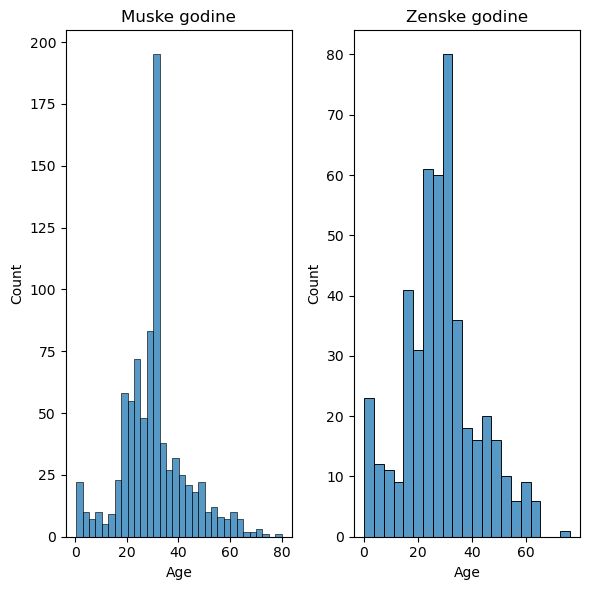

In [28]:
#skiciranje agea nakon imputea
sum(merged_pod['Age'].isna())
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(1,2,1)
sns.histplot(data=merged_pod[merged_pod['Sex'] == 'male'], x='Age', axes=ax)
ax.set_title('Muske godine')
ax=fig.add_subplot(1,2,2)
sns.histplot(data=merged_pod[merged_pod['Sex'] == 'female'], x='Age', axes=ax)
ax.set_title('Zenske godine')
fig.tight_layout()  # Improves appearance a bit
plt.show()

In [29]:
merged_pod['FS']=merged_pod['SibSp']+merged_pod['Parch']
train['FS']=merged_pod['FS'][0:891]
test['FS']=merged_pod['FS'][891:1309]

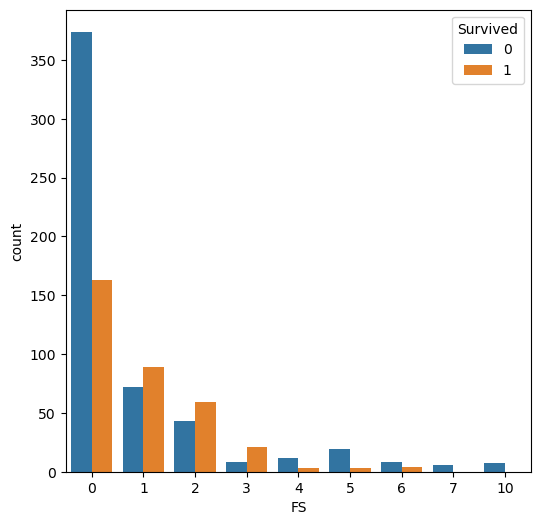

In [30]:
fig=plt.figure(figsize=(6,6))
sns.countplot(x='FS',hue='Survived',data=train)
plt.show()

In [31]:
#radimo 2 featurea pa cemo vidit koji je bolji (pri cemu moramo paziti na multikoreliranost)
#prvi feature je isalone, a drugi je fs_kat
# is_alone training set
train['Is_alone']=np.nan
train.loc[train['FS']==0,'Is_alone']='Alone'
train.loc[train['FS']>0,'Is_alone']='Not_alone'
#test set
test['Is_alone']=np.nan
test.loc[test['FS']==0,'Is_alone']='Alone'
test.loc[test['FS']>0,'Is_alone']='Not_alone'

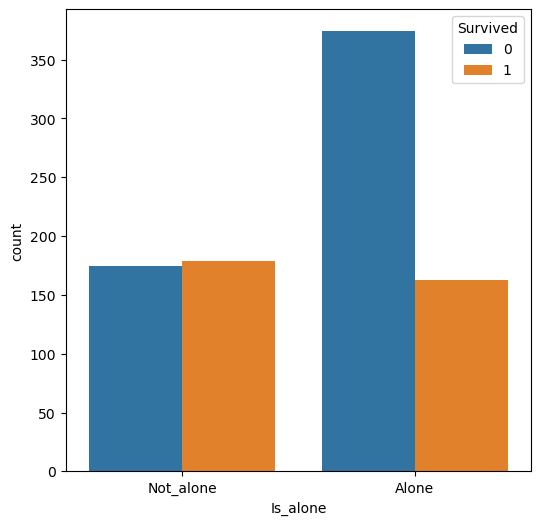

In [32]:
fig=plt.figure(figsize=(6,6))
sns.countplot(x='Is_alone',hue='Survived',data=train)
plt.show()

In [65]:
#raimio fs_kat
# is_alone training set
train['FS_kat']=np.nan
train.loc[train['FS']==0,'FS_kat']='K1'
train.loc[(train['FS']>0) & (train['FS']<4),'FS_kat']='K2'
train.loc[(train['FS']>=4),'FS_kat']='K3'
#test set
test['FS_kat']=np.nan
test.loc[test['FS']==0,'FS_kat']='K1'
test.loc[(test['FS']>0) & (test['FS']<4),'FS_kat']='K2'
test.loc[(test['FS']>=4),'FS_kat']='K3'

In [64]:
train[train['FS_kat']==np.nan][1:10]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,FS,Is_alone,FS_kat,Fare_rescaled,Fare_log_kat,Cabin_is_missing,Brojevi,Ime_karte_missing,Ime_kabine_kat,Age_kat


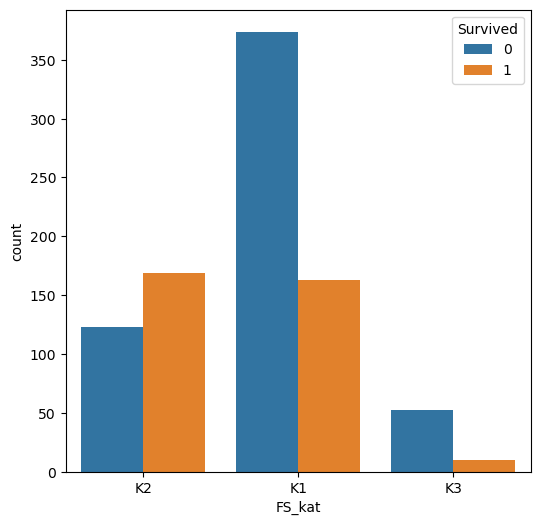

In [34]:
fig=plt.figure(figsize=(6,6))
sns.countplot(x='FS_kat',hue='Survived',data=train)
plt.show()

In [35]:
#radimo rescaling za fare kao 1+ln
merged_pod['Fare_rescaled']=np.log(merged_pod['Fare']+1)
train['Fare_rescaled']=merged_pod['Fare_rescaled'][0:891]
test['Fare_rescaled']=merged_pod['Fare_rescaled'][891:1309]

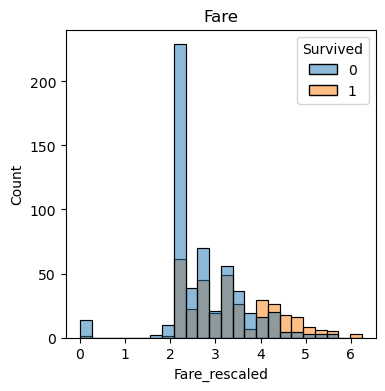

In [36]:
#radimo sad za fare
fig=plt.figure(figsize=(4,4))
sns.histplot(data=train, x='Fare_rescaled', hue='Survived').set_title('Fare')
plt.show()
#potencijalno kategorizirati??

In [37]:
#radimo fare_log_kat 
train['Fare_log_kat']=(train['Fare_rescaled']>3.8).astype(int)
test['Fare_log_kat']=(test['Fare_rescaled']>3.8).astype(int)

In [38]:
#gledmo ime
train.head()
#vadimo prvi dio strainga pa cemo drugi i 3. i gledait vec kako to ide
train['imena_names_t']=train['Name'].astype('string').str.split(', ').str[0]
train['titula_names_t']=train['Name'].astype('string').str.split(', ').str[1].astype('string').str.split('.').str[0]
train['ostalo_names_t']=train['Name'].astype('string').str.split(', ').str[1].astype('string').str.split('.').str[1]

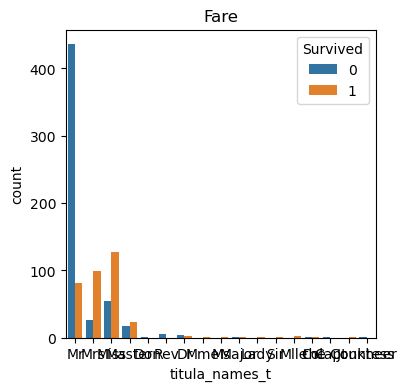

In [39]:
#gledmo titulu i survivied
fig=plt.figure(figsize=(4,4))
sns.countplot(data=train, x='titula_names_t', hue='Survived').set_title('Fare')
plt.show()
#potencijalno kategorizirati??

In [40]:
# Replace 'Master' with 'Mr'
train.loc[train['titula_names_t'] == 'Master', 'titula_names_t'] = 'Mr'
# Replace 'Miss' with 'Mrs'
train.loc[train['titula_names_t'] == 'Miss', 'titula_names_t'] = 'Mrs'
# Replace any other titles with 'Rare'
train.loc[(train['titula_names_t'] != 'Mr') & (train['titula_names_t'] != 'Mrs'), 'titula_names_t'] = 'Rare'

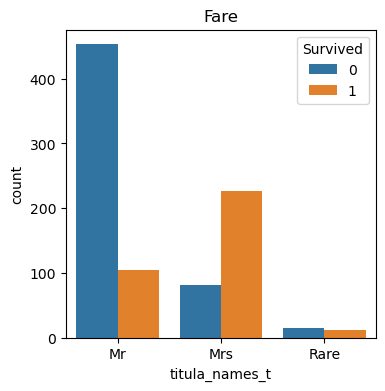

In [41]:
#gledmo titulu i survivied
fig=plt.figure(figsize=(4,4))
sns.countplot(data=train, x='titula_names_t', hue='Survived').set_title('Fare')
plt.show()

In [42]:
train['ostalo_names_t'][1:20]

1      John Bradley (Florence Briggs Thayer)
2                                      Laina
3              Jacques Heath (Lily May Peel)
4                              William Henry
5                                      James
6                                  Timothy J
7                              Gosta Leonard
8        Oscar W (Elisabeth Vilhelmina Berg)
9                     Nicholas (Adele Achem)
10                            Marguerite Rut
11                                 Elizabeth
12                             William Henry
13                              Anders Johan
14                     Hulda Amanda Adolfina
15                        (Mary D Kingcome) 
16                                    Eugene
17                            Charles Eugene
18       Julius (Emelia Maria Vandemoortele)
19                                    Fatima
Name: ostalo_names_t, dtype: object

In [43]:
#čupam prvi dio ticketa
imena=merged_pod['Ticket'].astype('string').str.split('\ ').str[0]
brojevi=merged_pod['Ticket'].astype('string').str.split('\ ').str[1]
#dohvacam indexe gdje su brojevi na i ubacujem sa tih indexa imena, a njih stavljam na na
indeksi=brojevi.isna()
brojevi[indeksi]=imena[indeksi]
imena[indeksi]=np.nan

In [44]:
#idemo napraviti nekakav cross tab za imena
imena.value_counts()

Ticket
PC            92
C.A.          46
SOTON/O.Q.    16
W./C.         14
STON/O        14
CA.           12
A/5           12
SC/PARIS      11
CA            10
A/5.          10
F.C.C.         9
SOTON/OQ       8
C              8
S.O.C.         7
S.O./P.P.      7
STON/O2.       7
A/4            6
SC/Paris       5
SC/AH          5
PP             4
SOTON/O2       3
A.5.           3
S.C./PARIS     3
F.C.           3
A/4.           3
A./5.          3
W.E.P.         2
P/PP           2
SC             2
WE/P           2
STON/OQ.       1
AQ/4           1
SC/A.3         1
C.A./SOTON     1
A.             1
LP             1
SC/A4          1
Fa             1
S.W./PP        1
A/S            1
SCO/W          1
SW/PP          1
W/C            1
S.O.P.         1
A4.            1
SO/C           1
S.P.           1
S.C./A.4.      1
AQ/3.          1
Name: count, dtype: int64

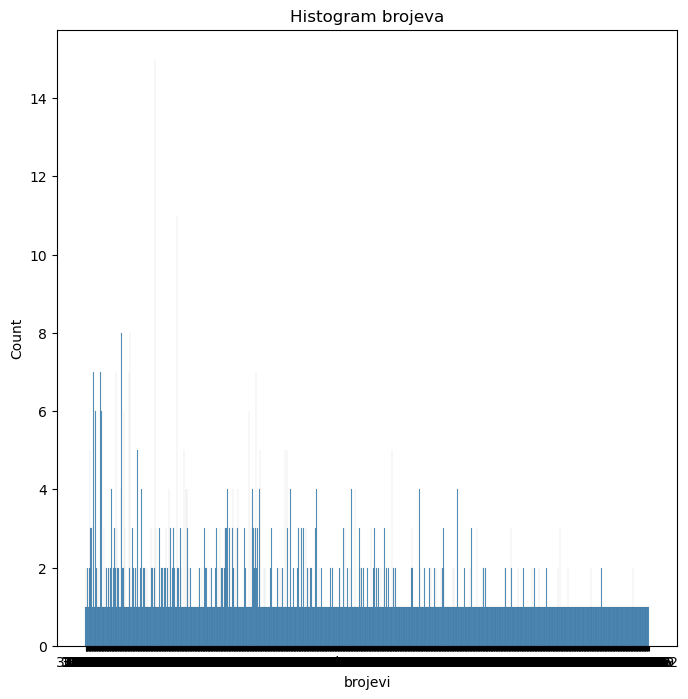

In [45]:
#histogram za brojeve
#idemo napraviti histogram
merged_pod['brojevi']=brojevi
fig=plt.figure(figsize=(8,8))
sns.histplot(data=merged_pod,x='brojevi').set_title('Histogram brojeva')
plt.show()

In [46]:
#radim isto na trainu
#čupam prvi dio ticketa
imena_t=train['Ticket'].astype('string').str.split('\ ').str[0]
brojevi_t=train['Ticket'].astype('string').str.split('\ ').str[1]
#dohvacam indexe gdje su brojevi na i ubacujem sa tih indexa imena, a njih stavljam na na
indeksi_t=brojevi_t.isna()
brojevi_t[indeksi_t]=imena_t[indeksi_t]
imena_t[indeksi_t]=np.nan

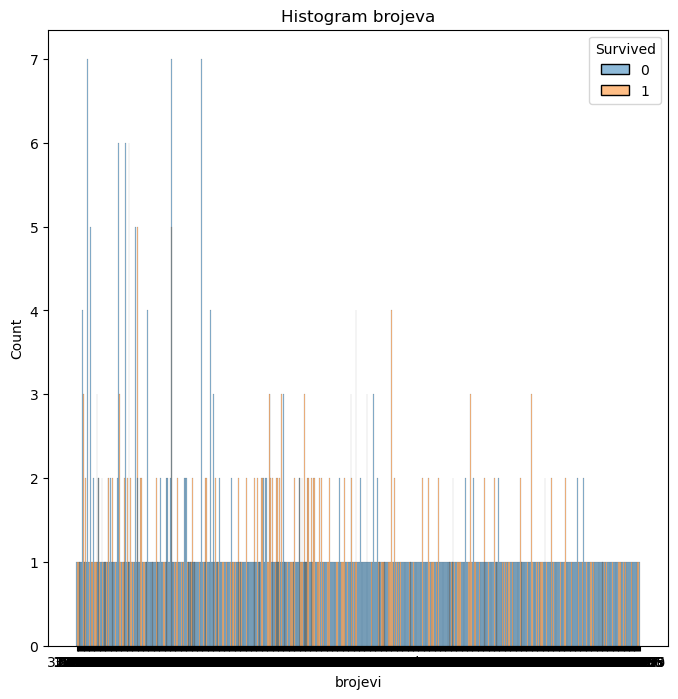

In [47]:
#histogram za brojeve
#idemo napraviti histogram
train['brojevi']=brojevi_t
fig=plt.figure(figsize=(8,8))
sns.histplot(data=train,hue='Survived',x='brojevi').set_title('Histogram brojeva')
plt.show()
#dobijem neki kurac

C:\Users\ante1\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


AttributeError: 'FacetGrid' object has no attribute 'set_title'

<Figure size 800x800 with 0 Axes>

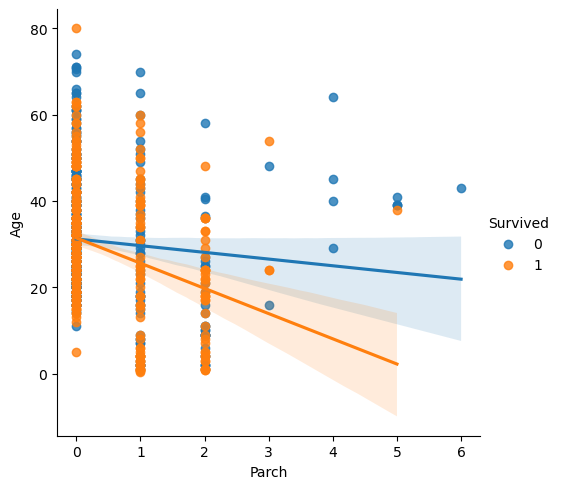

In [48]:
#gledmo godine i kakav feature mozemo od njih napraviti
fig=plt.figure(figsize=(8,8))
sns.lmplot(data=train,x='Parch',y='Age',hue='Survived').set_title('Godine_hue_survived')
plt.show()

In [49]:
#POPUNJAVANJE KREIRANIH VARIJABLI U TRAIN I TEST
train['Age']=merged_pod['Age'][0:891]
test['Age']=merged_pod['Age'][891:1309]
test['Cabin_is_missing'] = test['Cabin'].isna().astype(int)
train['Cabin_is_missing'] = train['Cabin'].isna().astype(int)
train['Imena_kabina']=imena[0:891]
test['Imena_kabina']=imena[891:1309]
train['Brojevi']=brojevi[0:891]
test['Brojevi']=brojevi[891:1309]
train['Ime_karte_missing']=train['Imena_kabina'].isna().astype(int)
test['Ime_karte_missing']=test['Imena_kabina'].isna().astype(int)

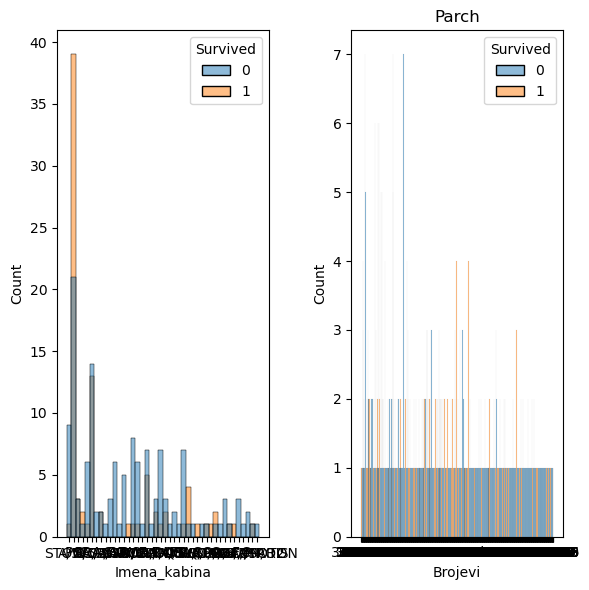

In [50]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(1,2,1)
sns.histplot(data=train,hue='Survived',x='Imena_kabina',axes=ax)
ax=fig.add_subplot(1,2,2)
sns.histplot(data=train,hue='Survived',x='Brojevi',axes=ax)
ax.set_title('Parch')
fig.tight_layout()  # Improves appearance a bit
plt.show()

In [51]:
pd.crosstab(train['Imena_kabina'],train['Survived'])
#na kabina ca i pc su ljudi dosta prezivili pa cemo napraviti kateogrijalnu na to kao dummy
train['Ime_kabine_kat']=train['Imena_kabina']
train.loc[train['Ime_kabine_kat'] == 'C.A.', 'Ime_kabine_kat'] = 0
train.loc[train['Ime_kabine_kat'] == 'PC', 'Ime_kabine_kat'] = 0
train.loc[train['Ime_kabine_kat'] != 0, 'Ime_kabine_kat'] = 1
test['Ime_kabine_kat'] = test['Imena_kabina']
test.loc[test['Ime_kabine_kat'] == 'C.A.', 'Ime_kabine_kat'] = 0
test.loc[test['Ime_kabine_kat'] == 'PC', 'Ime_kabine_kat'] = 0
test.loc[test['Ime_kabine_kat'] != 0, 'Ime_kabine_kat'] = 1

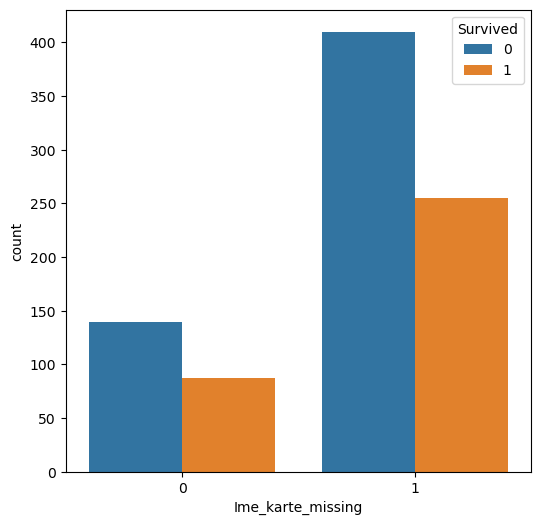

In [52]:
#deskriptiva grafova countplot za ime missing za ticket
fig=plt.figure(figsize=(6,6))
sns.countplot(data=train,hue='Survived',x='Ime_karte_missing') 
plt.show()
#dodajemo ga kao feature

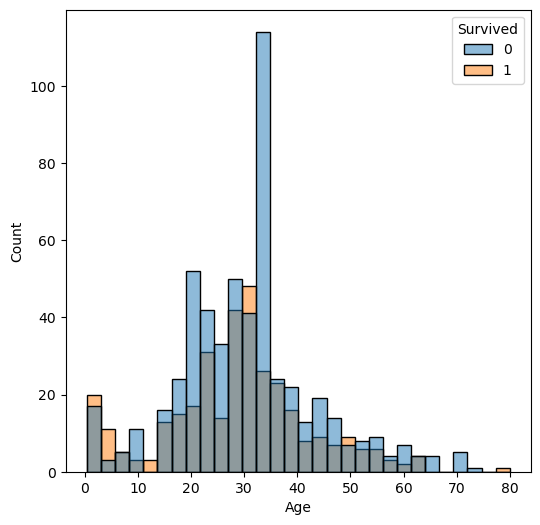

In [53]:
#deskriptiva grafova countplot za ime missing za ticket
fig=plt.figure(figsize=(6,6))
sns.histplot(data=train,hue='Survived',x='Age') 
plt.show()
#dodajemo ga kao feature

In [54]:
#raimio fs_kat
# is_alone training set
train['FS_kat']=np.nan
train.loc[train['Age']<7,'Age_kat']='K1'
train.loc[(train['Age']>=7) & (train['FS']<61),'Age_kat']='K2'
train.loc[(train['Age']>=61),'Age_kat']='K3'
#test set
test['FS_kat']=np.nan
test.loc[test['Age']<7,'Age_kat']='K1'
test.loc[(test['Age']>=7) & (test['FS']<61),'Age_kat']='K2'
test.loc[(test['Age']>=61),'Age_kat']='K3'

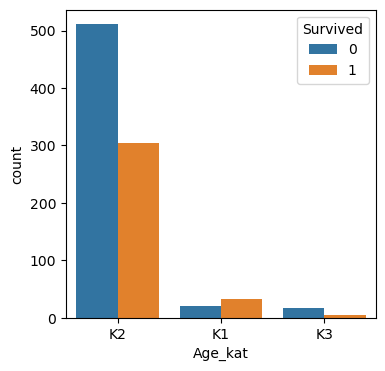

In [55]:
#radimo plot za to
fig=plt.figure(figsize=(4,4))
sns.countplot(data=train, x='Age_kat',hue='Survived')
plt.show()

In [56]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FS', 'Is_alone',
       'FS_kat', 'Fare_rescaled', 'Fare_log_kat', 'imena_names_t',
       'titula_names_t', 'ostalo_names_t', 'brojevi', 'Cabin_is_missing',
       'Imena_kabina', 'Brojevi', 'Ime_karte_missing', 'Ime_kabine_kat',
       'Age_kat'],
      dtype='object')

In [190]:
#ocistiti govna moram vec ovdje 
#pomocne varijable itd (sve sto nije feature)
train.drop(['PassengerId','Name','Ticket','Fare','Cabin'], axis=1, inplace=True)

In [57]:
#ovdje droppam feature koji ce mi mozda nekada biti korisni (oni gore siguno nece)
train.drop(['imena_names_t','titula_names_t', 'ostalo_names_t', 'brojevi','Imena_kabina'], axis=1, inplace=True)

In [58]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'FS', 'Is_alone', 'FS_kat',
       'Fare_rescaled', 'Fare_log_kat', 'Cabin_is_missing', 'Imena_kabina',
       'Brojevi', 'Ime_karte_missing', 'Ime_kabine_kat', 'Age_kat'],
      dtype='object')

In [60]:
test.drop(['PassengerId','Name','Ticket','Fare','Cabin'], axis=1, inplace=True)

In [59]:
#ovdje droppam feature koji ce mi mozda nekada biti korisni (oni gore siguno nece)
test.drop(['Imena_kabina'], axis=1, inplace=True)

IZ SVAKUOG STUPCA VADIM FEATURESE
ticket -> ime i broj
pclass, sex, age, sibsp, parch, fare, embarked ostaju isti
cabin_is_missing je ind za missing cabin
ime_kabine_kat je indikator za "bolja" imena kabine
name sam odlucio totalno ignorirat i izbacit

In [66]:
#ovdje exportam train i test u csv na komp
train.to_csv("C:\\Users\\ante1\\OneDrive\\Radna površina\\kaggle titanic\\train_novi.csv")
test.to_csv("C:\\Users\\ante1\\OneDrive\\Radna površina\\kaggle titanic\\test_novi.csv")